# <center> Trabalho 05 - Introdução ao Processamento de Imagem Digital </center>

**Aluna:** Marianna de Pinho Severo <br>
**RA**: 264960 <br>
**Professor:** Hélio Pedrini

### Passo 1: Importar bibliotecas

In [1]:
%matplotlib inline
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

### Passo 2: Definir funções auxiliares

#### Passo 2.1: Funções de apresentação

Função utilizada para plotar todas as imagens.

In [2]:
def plotAllImages(images, color='rgb'):
    columns = 4
    rows = 3
    i = 1
    fig=plt.figure(figsize=(15, 15))
    
    for key in images:
        fig.add_subplot(rows, columns, i)
        plt.xlabel(key)
        if color == 'rgb':
            plt.imshow(cv.cvtColor(images[key], cv.COLOR_BGR2RGB))
        else:
            plt.imshow(images[key],cmap='gray', vmin=0, vmax=255)
        i = i+1

    plt.subplots_adjust(bottom=0.20, top=0.75)
    plt.show()

Função para plotar os pares de imagens com as linhas de correspondências entre elas.

In [3]:
# Baseado no código disponível em: https://docs.opencv.org/master/dc/dc3/tutorial_py_matcher.html
def plotCorrespondingLines(images, matches, keypoints):
    columns = 5
    rows = 8
    i = 1
    fig=plt.figure(figsize=(15, 15))

    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                       singlePointColor = None)

    for key in matches:
        _,key1,key2,_ = key.split('_')

        fig.add_subplot(rows, columns, i)
        plt.xlabel(key)

        imMatches = cv.drawMatches(images[key1], keypoints[key1], images[key2], keypoints[key2], matches[key], None, **draw_params)
        plt.imshow(cv.cvtColor(imMatches,cv.COLOR_BGR2RGB))
        i = i+1

    # plt.subplots_adjust(bottom=0.20, top=0.75)
    plt.show()

#### Passo 2.2: Funções para salvar imagens

Função que salva os pares de imagens, com linhas de correspondências entre elas.

In [4]:
def saveCorrespondingLines(images, matches, keypoints):
    draw_params = dict(matchColor = (0,255,0), singlePointColor = None)
    
    for key in matches:
        subkey1,subkey2,subkey3,_ = key.split('_')
        
        imMatches = cv.drawMatches(images[subkey2], keypoints[subkey2], images[subkey3], keypoints[subkey3], matches[key], None, **draw_params)
        cv.imwrite('output_images/'+subkey1+'/lines/'+key+'.jpg',imMatches)

#### Passo 2.3: Funções para cálculos

Função que retorna apenas os pontos correspondentes cujas correspondências são maiores do que um determinado limiar. Para calcular a correspodência, normalizamos as distâncias entre pares de pontos correspondentes, deixando-as no intervalo [0,1]. Então, subtraímos esse valor de 1, de maneira que, quanto menor for a distância entre dois pontos, maior vai ser a correspondência.

Como não sabemos a máxima distância possível entre dois pontos, para normalizarmos as distâncias, utilizamos a maior distância dentre as obtidas.

In [5]:
def getCorrespondingMatches(matches, corr_level=0.5):
    if matches == []:
        return []
    
    distances = [m.distance for m in matches]
    distances = distances/np.max(distances)
    
    corr_values = np.ones((1,len(distances))) - distances
    corr_indexes = np.where(corr_values >= corr_level)[1]
    
    corresponding = [matches[idx] for idx in corr_indexes]
    
    return corresponding if len(corresponding) > 0 else []

### Passo 3: Ler imagens

In [6]:
images = {}

In [7]:
images['building1'] = cv.imread('input_images/foto1A.jpg')
images['building2'] = cv.imread('input_images/foto1B.jpg')
images['lake1'] = cv.imread('input_images/foto2A.jpg')
images['lake2'] = cv.imread('input_images/foto2B.jpg')
images['road1'] = cv.imread('input_images/foto3B.jpg')
images['road2'] = cv.imread('input_images/foto3A.jpg')
images['desertroad1'] = cv.imread('input_images/foto4A.jpg')
images['desertroad2'] = cv.imread('input_images/foto4B.jpg')
images['field1'] = cv.imread('input_images/foto5A.jpg')
images['field2'] = cv.imread('input_images/foto5B.jpg')

### Passo 4: Converter imagens para a escala de cinza

In [8]:
gray_images = {}

In [9]:
for key in images:
    gray_images[key] = cv.cvtColor(images[key], cv.COLOR_BGR2GRAY)

In [10]:
# plotAllImages(gray_images, 'gray')

### Passo 5: Encontrar pontos de interesse e descritores invariantes

Para encontrarmos pontos de interesse e calcularmos seus descritores, utilizaremos dois métodos, escolhidos por serem métodos não pagos. O primeiro deles é o ORB (*Oriented FAST and Rotated BRIEF*), que pode ser utilizando tanto para identificarmos os pontos de interesse como para calcularmos seus descritores. O segundo método é o BRIEF (*Binary Robust Independent Elementary Features*), que é utilizado apenas para o cálculo dos descritores. 

Um detalhe importante com relação ao BRIEF é que precisamos utilizar um outro algoritmo para a identificação dos pontos de interesse e então passamos estes para o BRIEF para que ele calcule os descritores. Segundo o tutorial do *Opencv*, um bom algoritmo para a identificação dos pontos de interesse seria o *Star*. Entretanto, ao aplicarmos ele não obtivemos pontos de interesse para as imagens Field1 e Field2. Dessa forma, decidimos utilizar o detector do ORB para esse fim.

In [11]:
image_keys = list(gray_images.keys())

#### Passo 5.1: Aplicar ORB

In [12]:
orb_keypoints = {}
orb_descriptors = {}

In [13]:
orb = cv.ORB_create()

for key in gray_images:
    orb_keypoints[key], orb_descriptors[key] = orb.detectAndCompute(gray_images[key],None)

#### Passo 5.2: Aplicar BRIEF

In [14]:
brief_keypoints = {}
brief_descriptors = {}

In [15]:
orb = cv.ORB_create()
brief = cv.xfeatures2d.BriefDescriptorExtractor_create()

In [16]:
for key in gray_images:
    brief_keypoints[key] = orb.detect(gray_images[key],None)
    brief_keypoints[key], brief_descriptors[key] = brief.compute(gray_images[key], brief_keypoints[key])

### Passo 6: Calcular similaridades e selecionar melhores correspondências

Para calcularmos as similaridades entre as imagens, utilizamos o método BFMatcher (*Brute Force Matcher*). Nele, cada descritor em uma imagem é comparado com todos os outros descritores da outra imagem e o *match* que tem a menor distância é retornado. Um detalhe importante é que, ao passarmos o valor *True* para a flag *crossCheck* desse método, ele só vai retornar os matches em que os descritores das duas imagens são os mais próximos um do outro, ou seja, o descritor na imagem 2 é o mais próximo daquele da imagem 1 e vice-versa.

Além de utilizarmos o *crossCheck* como um critério de seleção, também empregados a função *getCorrespondingMatches*, que retorna apenas os matches cuja correspondência seja maior do que um determinado limiar, em que a correspondência é igual a 1 menos a distância entre os descritores. Um detalhe importante dessa função é que ela utiliza uma normalização relativa, em que as distâncias são normalizadas pela maior distância obtida e não pela maior distância possível entre dois descritores.

Por fim, para fins de análise, calculamos o matching para diferentes limiares de correspondência, conforme pode ser visto abaixo.

In [17]:
aux_orb_matches = {}
orb_matches = {}

aux_brief_matches = {}
brief_matches = {}

In [18]:
brute_force = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

In [19]:
corr_levels = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

#### Passo 6.1: Calcular similaridades e crossCheck matches

In [20]:
pos = 0
while pos < len(image_keys):
    key1 = image_keys[pos]
    key2 = image_keys[pos+1]
    match_key = key1+'_'+key2
    
    aux_orb_matches[match_key] = brute_force.match(orb_descriptors[key1],orb_descriptors[key2])
    aux_orb_matches[match_key] = sorted(aux_orb_matches[match_key], key = lambda x:x.distance)
    
    aux_brief_matches[match_key] = brute_force.match(brief_descriptors[key1],brief_descriptors[key2])
    aux_brief_matches[match_key] = sorted(aux_brief_matches[match_key], key = lambda x:x.distance)
    
    pos+=2

#### Passo 6.2: Selecionar melhores correspondências

In [21]:
for lvl in corr_levels:
    for key in aux_orb_matches:
        orb_matches['orb_'+key+'_'+str(lvl)] = getCorrespondingMatches(aux_orb_matches[key],lvl)
    for key in aux_brief_matches:
        brief_matches['brief_'+key+'_'+str(lvl)] = getCorrespondingMatches(aux_brief_matches[key], lvl)

### Passo 7: Estimar matrizes de homografia

Para calcularmos as matrizes de homografia para todos os pares de imagens, utilizamos o método RANSAC (*RANdom SAmple Consensus*). Para fins de análise, criamos matrizes de acordo com diferentes limiares de erro, conforme pode ser visto abaixo, permitindo uma variação dos pontos considerados *inliers* e *outliers*.

In [22]:
orb_homography_matrix = {}
brief_homography_matrix = {}

In [23]:
ransac_thresholds = list(np.arange(1,10.5,0.5))

In [24]:
for thre in ransac_thresholds:
    for key in orb_matches:
        points1 = np.zeros((len(orb_matches[key]), 2), dtype=np.float32)
        points2 = np.zeros((len(orb_matches[key]), 2), dtype=np.float32)

        if len(orb_matches[key])>=4:
            for i, match in enumerate(orb_matches[key]):
                _,subkey1,subkey2,_ = key.split('_')

                points1[i, :] = (orb_keypoints[subkey1])[match.queryIdx].pt
                points2[i, :] = (orb_keypoints[subkey2])[match.trainIdx].pt

            orb_homography_matrix[key+'_'+str(thre)], mask = cv.findHomography(points1, points2, cv.RANSAC, thre)
    

In [25]:
for thre in ransac_thresholds:
    for key in brief_matches:
        points1 = np.zeros((len(brief_matches[key]), 2), dtype=np.float32)
        points2 = np.zeros((len(brief_matches[key]), 2), dtype=np.float32)

        if len(brief_matches[key])>=4:
            for i, match in enumerate(brief_matches[key]):
                _,subkey1,subkey2,_ = key.split('_')

                points1[i, :] = (brief_keypoints[subkey1])[match.queryIdx].pt
                points2[i, :] = (brief_keypoints[subkey2])[match.trainIdx].pt

            brief_homography_matrix[key+'_'+str(thre)], mask = cv.findHomography(points1, points2, cv.RANSAC,thre)
    

In [ ]:
# i = 0
# for key in brief_homography_matrix:
#     print("{} - key:{}\n{}".format(i,key, brief_homography_matrix[key]))
#     i+=1

In [ ]:
# i = 0
# for key in orb_homography_matrix:
#     print("{} - key:{}\n{}".format(i,key, orb_homography_matrix[key]))
#     i+=1

### Passo 8: Alinhar e unir imagens para formar imagens panorâmicas

In [32]:
orb_panoramic_images = {}
brief_panoramic_images = {}

In [27]:
for key in orb_homography_matrix:
    _,subkey1,subkey2,_,_ = key.split('_')
    
    img1 = images[subkey1]
    img2 = images[subkey2]
    
    height, width,deep = img2.shape
    orb_panoramic_images[key] = cv.warpPerspective(img1, orb_homography_matrix[key], (width+img1.shape[1], height+img1.shape[0]))
    (orb_panoramic_images[key])[:img2.shape[0],:img2.shape[1]] = img2

In [30]:
for key in brief_homography_matrix:
    _,subkey1,subkey2,_,_ = key.split('_')
    
    img1 = images[subkey1]
    img2 = images[subkey2]
    
    height, width,deep = img2.shape
    brief_panoramic_images[key] = cv.warpPerspective(img1, brief_homography_matrix[key], (width+img1.shape[1], height+img1.shape[0]))
    (brief_panoramic_images[key])[:img2.shape[0],:img2.shape[1]] = img2

### Passo 9: Mostrar imagens com linhas de correspondências

#### Passo 9.1: Correspondências resultantes dos pontos de interesse obtidos pelo ORB

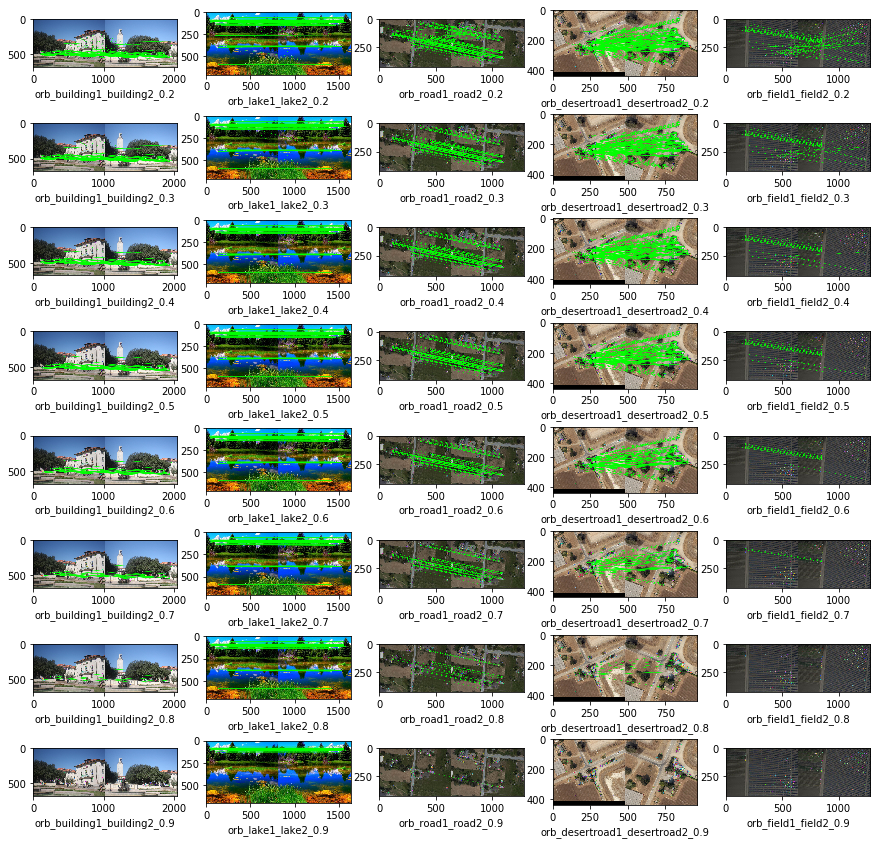

In [33]:
plotCorrespondingLines(images,orb_matches, orb_keypoints)

#### Passo 9.2: Correspondências resultantes dos pontos de interesse obtidos pelo BRIEF

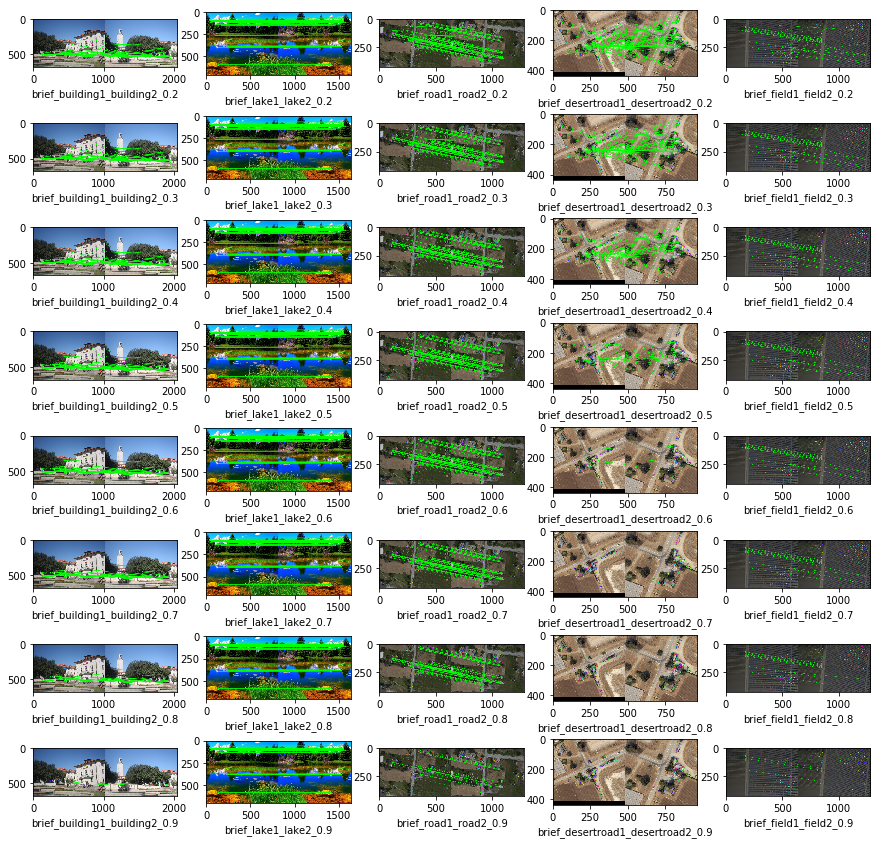

In [34]:
plotCorrespondingLines(images, brief_matches, brief_keypoints)

### Passo 10: Salvar imagens

#### Passo 10.1: Salvar imagens panorâmicas

In [28]:
# for key in orb_panoramic_images:
#     cv.imwrite('output_images/orb/panoramic/'+key+'.jpg', orb_panoramic_images[key])

In [31]:
# for key in brief_panoramic_images:
#     cv.imwrite('output_images/brief/panoramic/'+key+'.jpg', brief_panoramic_images[key])

#### Passo 10.2: Salvar imagens com linhas de correspondência

In [35]:
# saveCorrespondingLines(images,orb_matches, orb_keypoints)

In [36]:
# saveCorrespondingLines(images,brief_matches, brief_keypoints)